# Proyecto: Análisis de la pandemia por COVID-19 en el mundo

A continuación analizaremos una base de datos con más de 300 mil REGISTROS DIARIOS corresponduentes al número de contagios, muertes y recuperación por COVID-19 en distintos países del mundo. Los registros van del 22 de Enero de 2020 al 29 de Mayo de 2021.

Responderemos a las siguientes preguntas:

* ¿Qué países registran el mayor número de casos confirmados?

* ¿Qué países registran la mayor tasa de mortalidad?

* ¿Cómo ha evolucionado el número de contagios en México?

* ¿Cuál es la tendencia de contagios en México?

* Estimar el número de contagios en México para las próximas 10 semanas

Utilizaremos regresores y redes neuronales para responder a algunas de las preguntas anteriores.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Libreria para realizar regresión lineal y estimar la tendencia
from sklearn.linear_model import LinearRegression

# importamos el cálculo del error cuadrático medio (MSE)
from sklearn.metrics import mean_squared_error

## Exploración de datos

In [2]:
# Cargamos datos:
df = pd.read_csv('./Data/covid_19_data.csv')
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,05/29/2021,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,05/29/2021,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,05/29/2021,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,05/29/2021,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [3]:
# Extraemos información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province/State   228329 non-null  object 
 3   Country/Region   306429 non-null  object 
 4   Last Update      306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [4]:
# Vemos que las variables 'ObservationDate' y 'Last Update' son fechas con un tipo de dato incorrecto, 
# así que las converitemos al tipo 'datetime'

# Convertimos los valores de la variable 'ObservationDate' al tipo datetime
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])#, format='%m/%d/%Y')

# Convertimos los valores de la variable 'Last Update' al tipo datetime
df['Last Update'] = pd.to_datetime( df['Last Update'])#,format='%m/%d/%Y %H:%M')

In [5]:
# Verfificamos que se hayan aplicado los cambios:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              306429 non-null  int64         
 1   ObservationDate  306429 non-null  datetime64[ns]
 2   Province/State   228329 non-null  object        
 3   Country/Region   306429 non-null  object        
 4   Last Update      306429 non-null  datetime64[ns]
 5   Confirmed        306429 non-null  float64       
 6   Deaths           306429 non-null  float64       
 7   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 18.7+ MB


In [6]:
# Eliminamos las columnas ['SNo','Province/State','Last Update']
df.drop( columns=['SNo','Province/State','Last Update']  , inplace = True)

In [7]:
# Nos quedamos únicamente con los países en donde se ha presentado al menos un caso de contagio y una muerte por COVID-19
df = df[ (df['Confirmed']>0) & (df['Deaths']>0)]

In [8]:
# Por cuestiones didácticas vamos a suponer que 'casos recuperados' = 'casos confirmados' - 'muertes'
df['Recovered'] = df['Confirmed'] - df['Deaths']

<ipython-input-8-da11f7689d96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Recovered'] = df['Confirmed'] - df['Deaths']


In [9]:
df

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
13,2020-01-22,Mainland China,444.0,17.0,427.0
49,2020-01-23,Mainland China,444.0,17.0,427.0
53,2020-01-23,Mainland China,444.0,17.0,427.0
88,2020-01-24,Mainland China,549.0,24.0,525.0
107,2020-01-24,Mainland China,4.0,1.0,3.0
...,...,...,...,...,...
306424,2021-05-29,Ukraine,102641.0,2335.0,100306.0
306425,2021-05-29,Netherlands,29147.0,245.0,28902.0
306426,2021-05-29,Mainland China,1364.0,1.0,1363.0
306427,2021-05-29,Ukraine,87550.0,1738.0,85812.0


## ¿Qué paises registran el mayor número de casos confirmados? y  ¿Qué paises registran la mayor tasa de mortalidad?

In [10]:
# Obtenemos la suma de registros agrupados por 'Country/Region'
df_sum = df.groupby( ['Country/Region'] ).sum()

df_sum


,Confirmed,Deaths,Recovered
Country/Region,,,
Afghanistan,17026183.0,669075.0,16357108.0
Albania,19768857.0,375955.0,19392902.0
Algeria,27684207.0,834464.0,26849743.0
Andorra,2379492.0,32100.0,2347392.0
Angola,4764836.0,116489.0,4648347.0
...,...,...,...
Vietnam,573895.0,10220.0,563675.0
West Bank and Gaza,41819444.0,440378.0,41379066.0
Yemen,962041.0,237613.0,724428.0


In [11]:
# Agregamos una columna que contiene la tasa de mortalidad:
df_sum['death_rate'] = (df_sum.Deaths / df_sum.Confirmed)*100

df_sum

,Confirmed,Deaths,Recovered,death_rate
Country/Region,,,,
Afghanistan,17026183.0,669075.0,16357108.0,3.929683
Albania,19768857.0,375955.0,19392902.0,1.901754
Algeria,27684207.0,834464.0,26849743.0,3.014224
Andorra,2379492.0,32100.0,2347392.0,1.349027
Angola,4764836.0,116489.0,4648347.0,2.444764
...,...,...,...,...
Vietnam,573895.0,10220.0,563675.0,1.780814
West Bank and Gaza,41819444.0,440378.0,41379066.0,1.053046
Yemen,962041.0,237613.0,724428.0,24.698843


In [12]:
min_rate = 0
max_rate = 100

min_confirm = df_sum['Confirmed'].min()
max_confirm = df_sum['Confirmed'].max()

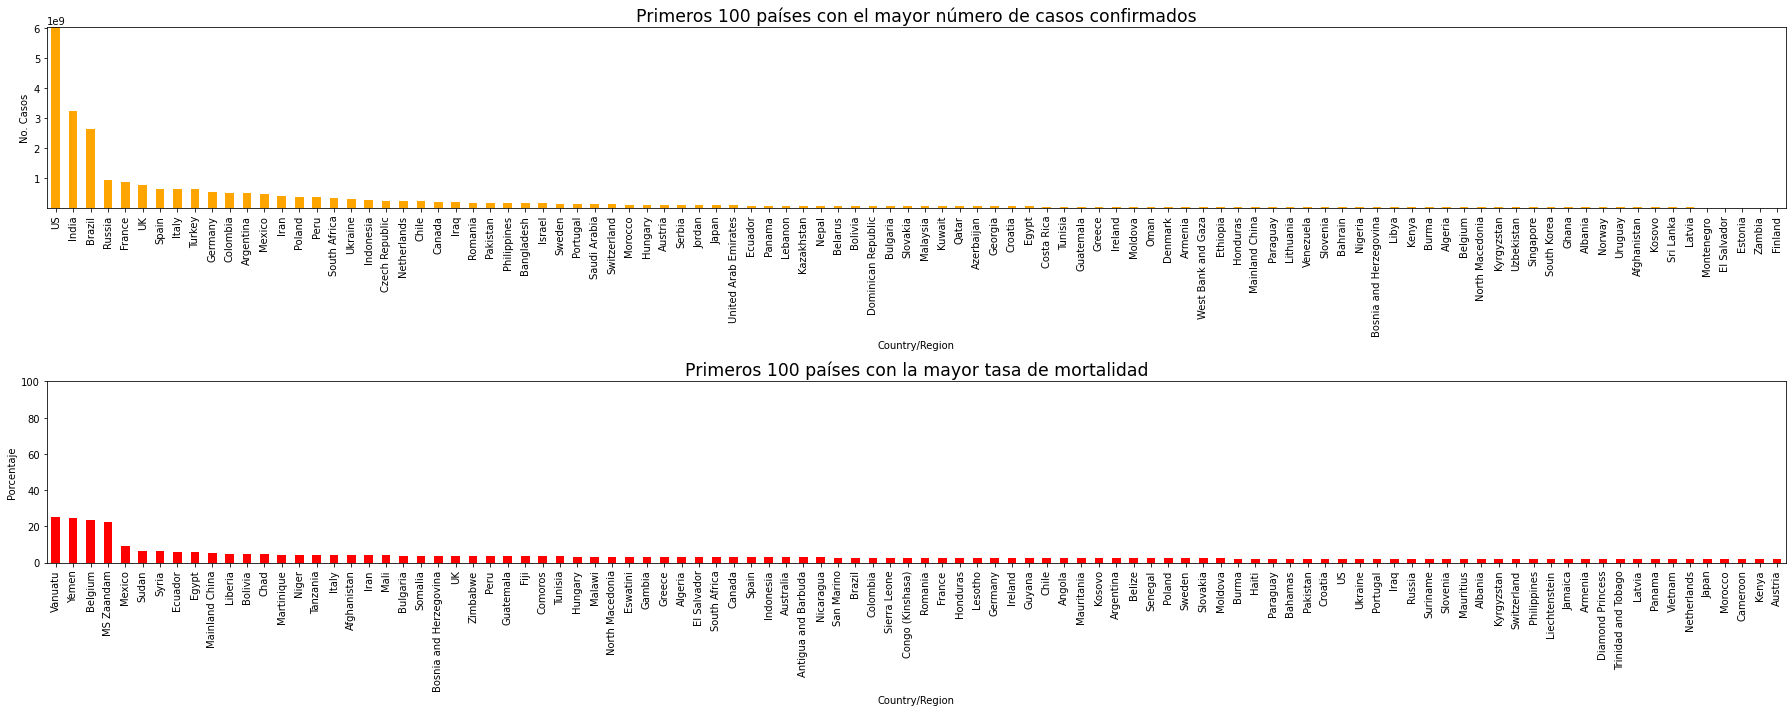

In [13]:
N = 100 # <-- Número de registros a graficar
rot_text = 90 # <-- Grados de rotación de texto

plt.figure(figsize=[25,10])
#plt.suptitle('Gráficos de los primeros 30 países', fontsize="xx-large")

# Graficamos el número de casos confirmados en cada país:
plt.subplot(2,1,1)
df_sum['Confirmed'].sort_values(ascending=False).iloc[0:N].plot(kind='bar',rot=rot_text , color = 'orange')
plt.title('Primeros ' + str(N) + ' países con el mayor número de casos confirmados' , fontsize="xx-large")
plt.ylim(min_confirm,max_confirm) # límites en el eje y
plt.ylabel('No. Casos')


# Graficamos tasa de mortalidad en cada país:
plt.subplot(2,1,2)
df_sum['death_rate'].sort_values(ascending=False).iloc[:N].plot(kind='bar',rot=rot_text , color = 'red')
plt.title('Primeros '+ str(N) +' países con la mayor tasa de mortalidad', fontsize="xx-large")
plt.ylim(min_rate,max_rate)# límites en el eje y
plt.ylabel('Porcentaje')

plt.tight_layout()
plt.show()


De las gráficas anteriores podemos ver que US presenta el mayor número de casos confirmados, sin embargo, presenta una tasa de mortalidad menor a la de otros países en donde había menos contagios

# ¿Cómo ha evolucionado el número de contagios en México?

In [14]:
# Registros restringidos a 'México'
df[ df['Country/Region']=='Mexico' ]

,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
6939,2020-03-19,Mexico,118.0,1.0,117.0
7220,2020-03-20,Mexico,164.0,1.0,163.0
7520,2020-03-21,Mexico,203.0,2.0,201.0
7833,2020-03-22,Mexico,251.0,2.0,249.0
8136,2020-03-23,Mexico,316.0,3.0,313.0
...,...,...,...,...,...
306328,2021-05-29,Mexico,59573.0,5017.0,54556.0
306341,2021-05-29,Mexico,19921.0,2455.0,17466.0
306389,2021-05-29,Mexico,61482.0,9867.0,51615.0
306418,2021-05-29,Mexico,39748.0,3917.0,35831.0


In [15]:
# Realizamos la suma de registros en México, agrupados con respecto a las fechas 'ObservationDate' 
df_sum_Mexico = df[ df['Country/Region']=='Mexico' ].groupby(['ObservationDate']).sum()
df_sum_Mexico

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-03-19,118.0,1.0,117.0
2020-03-20,164.0,1.0,163.0
2020-03-21,203.0,2.0,201.0
2020-03-22,251.0,2.0,249.0
2020-03-23,316.0,3.0,313.0
...,...,...,...
2021-05-25,2399790.0,221960.0,2177830.0
2021-05-26,2402722.0,222232.0,2180490.0
2021-05-27,2405772.0,222661.0,2183111.0


In [16]:
# Extraemos un registro de sumas acumuladas en una frecuencia de tiempo dada:

freq = '1w' #'1w' <-- cada 1 week  '1M' <-- cada 1 Mes, '15d' <-- cada 15 días
n_freq = 'cada semana'

df_sum_Mexico_freq = df_sum_Mexico.resample(freq).sum()
df_sum_Mexico_freq

,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-03-22,736.0,6.0,730.0
2020-03-29,3713.0,54.0,3659.0
2020-04-05,9768.0,303.0,9465.0
2020-04-12,22052.0,1234.0,20818.0
2020-04-19,41590.0,3165.0,38425.0
...,...,...,...
2021-05-02,16381946.0,1514333.0,14867613.0
2021-05-09,16509963.0,1527835.0,14982128.0
2021-05-16,16622095.0,1538883.0,15083212.0


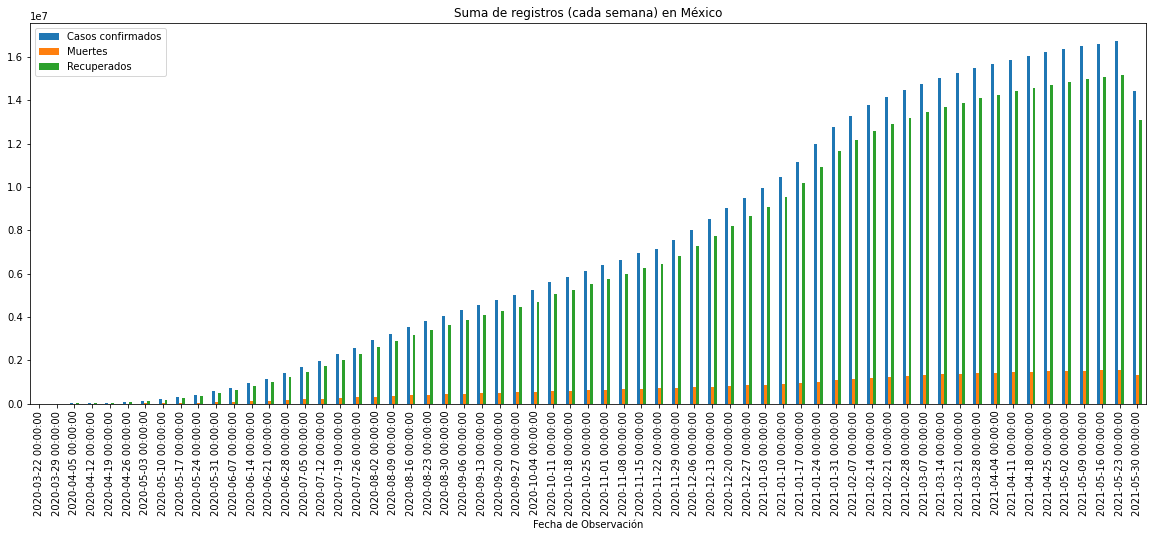

In [17]:
df_sum_Mexico_freq.plot(kind="bar", figsize=(20,7), rot = 90, legend = False).legend(['Casos confirmados','Muertes','Recuperados'])
plt.title('Suma de registros ('+str(n_freq)+') en México')
plt.xlabel('Fecha de Observación')
plt.show()

In [18]:
# Tasa de mortalidad
death_rate_mex = df_sum_Mexico_freq['Deaths']/df_sum_Mexico_freq['Confirmed']*100
death_rate_mex

ObservationDate
2020-03-22    0.815217
2020-03-29    1.454350
2020-04-05    3.101966
2020-04-12    5.595864
2020-04-19    7.610002
                ...   
2021-05-02    9.243914
2021-05-09    9.254018
2021-05-16    9.258057
2021-05-23    9.250536
2021-05-30    9.254727
Freq: W-SUN, Length: 63, dtype: float64

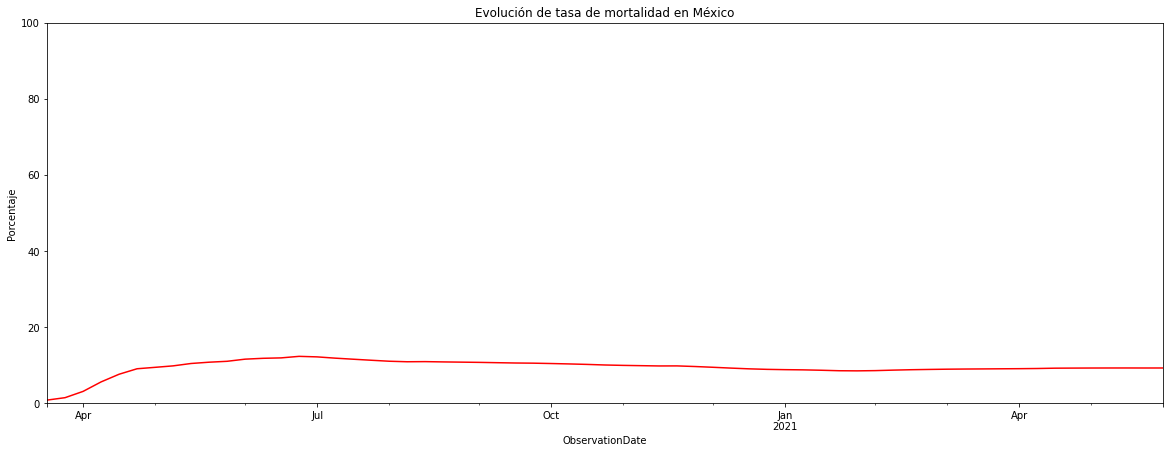

In [19]:
death_rate_mex.plot(figsize=(20,7), color='red')
plt.ylim(min_rate,max_rate)# límites en el eje y
plt.title('Evolución de tasa de mortalidad en México')
plt.ylabel('Porcentaje')
plt.show()


## ¿Cuál es la tendencia de contagios en México?

In [20]:
# Reseteamos índices
df_sum_Mexico_freq.reset_index()


,ObservationDate,Confirmed,Deaths,Recovered
0,2020-03-22,736.0,6.0,730.0
1,2020-03-29,3713.0,54.0,3659.0
2,2020-04-05,9768.0,303.0,9465.0
3,2020-04-12,22052.0,1234.0,20818.0
4,2020-04-19,41590.0,3165.0,38425.0
...,...,...,...,...
58,2021-05-02,16381946.0,1514333.0,14867613.0
59,2021-05-09,16509963.0,1527835.0,14982128.0
60,2021-05-16,16622095.0,1538883.0,15083212.0
61,2021-05-23,16730587.0,1547669.0,15182918.0


### Regresión lineal

In [21]:
# Extraemos los índices, que serán usados como "features" para entrenar modelos
x = df_sum_Mexico_freq.reset_index().index.values
x = x[0:-1] # <-- no consideramos el último registro ya que esta incompleto 

In [22]:
# Redimensionamos los "features" como vector columna para poderelos usar en los entrenamientos
x = x.reshape( x.shape[0],1 )
x.shape

(62, 1)

In [23]:
x

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61]])

In [24]:
# Extraemos los valores de la columna 'Confirmed', los cuales serán usados como "labels" en la regresión lineal
y = df_sum_Mexico_freq['Confirmed'].values
y = y[0:-1] # <-- no consideramos el último registro ya que esta incompleto 
y.shape

(62,)

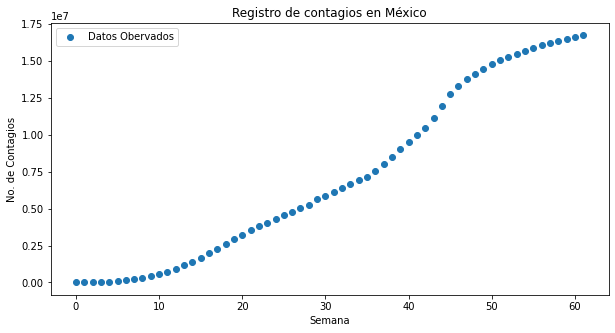

In [25]:
plt.figure(figsize=[10,5])
plt.plot(x,y,'o',label='Datos Obervados')
plt.title('Registro de contagios en México')
plt.xlabel('Semana')
plt.ylabel('No. de Contagios')
plt.legend()
plt.show()

In [26]:
# Declaramos el modelo de regresión
reg_lin = LinearRegression()

In [27]:
# Entrenamos el modelo:
reg_lin.fit(x, y) 

LinearRegression()

In [28]:
# Evaluamos los resultados del modelo entrenado:

# Predecimos los valores 'y' para los datos usados en el entrenamiento
y_aprox = reg_lin.predict(x)


# Calculamos el Error Cuadrático Medio (MSE = Mean Squared Error)
mse = mean_squared_error(y_true = y, y_pred = y_aprox)

print('Error cuadrático medio = ',mse)

Error cuadrático medio =  1055786632941.7334


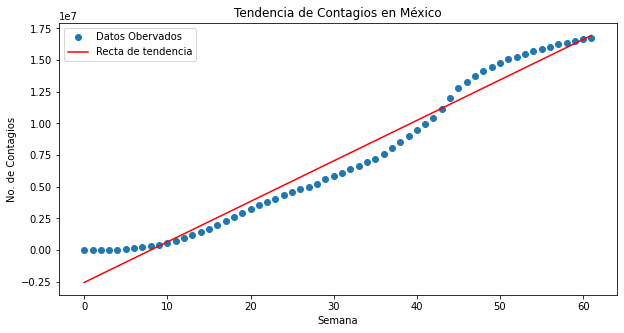

In [29]:
plt.figure(figsize=[10,5])
plt.plot(x,y,'o',label='Datos Obervados')
plt.plot(x,y_aprox, label='Recta de tendencia', color='r')
plt.title('Tendencia de Contagios en México')
plt.xlabel('Semana')
plt.ylabel('No. de Contagios')
plt.legend()
plt.show()

### Los contagios por COVID-19 en México van a la alta

## ¿Cuál será el número de contagios en México estimado en las próximas 10 semanas?
### Regresión no lineal con Redes Neuronales

In [30]:
# Librería para separar datos:
from sklearn.model_selection import train_test_split

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers


In [31]:
# Estandarizamos features para entrenamiento:
x_mu = x.mean()
x_std = x.std()

x_features = (x-x_mu)/x_std

In [32]:
# Particionamos datos para entrenamiento, validacion y pruebas como sigue:

p_train=0.8  # porcentaje para datos de entrenamiento
p_test = 0.2 # porcentaje para datos de prueba

# Del total de datos usamos el 80% para entrenamiento y el resto para pruebas:
x_train, x_test , y_train, y_test = train_test_split ( x_features , y , train_size=p_train , test_size=p_test)

# A partir de los datos de entrenamiento, exraemos 20% para validación y el resto para entrenamiento:
x_train, x_valid , y_train, y_valid = train_test_split ( x_train , y_train , train_size=p_train , test_size=p_test)

print('x_train.shape = ',x_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('x_test.shape = ',x_test.shape)


x_train.shape =  (39, 1)
x_valid.shape =  (10, 1)
x_test.shape =  (13, 1)


In [33]:
# Extraemos la dimensión de los features para entrenar la red:
dim_feature = x_train[0].shape
dim_feature

(1,)

In [34]:
# Construimos la red dentro de una función:

# Parametros de entrada: 'dimension del feature' y 'learning rate'
def build_model( dim_feature , lr ):

    # numero de neuronas en cada capa:
    nn = 50 

    # Construimos arquitectura de la red:
    model = models.Sequential()    
    # Capa 1 (entrada)
    model.add( layers.Dense(nn, activation='relu', input_shape=dim_feature ))
    # Capa 2
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 3
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 4
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 5
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 6    
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 7
    model.add( layers.Dense(nn, activation='relu' ))
    # Capa 8
    #model.add( layers.Dense(nn, activation='relu' ))
    # Capa 9
    #model.add( layers.Dense(nn, activation='relu' ))
    # Capa 10
    #model.add( layers.Dense(nn, activation='relu' ))
    
    # Capa de salida (una sóla neurona sin función de activación para problemas de regresión)
    model.add( layers.Dense(1) )

    # visualzamos la arquitecura de la red:
    # model.summary()

    # optimizador:
    optim_meth = optimizers.Nadam(learning_rate=lr)

    # compilamos la red:
    model.compile(
        optimizer= optim_meth,
        loss='mse',  # <-- Función de costo a minimizar: mean square error (para problemas de regresión)
        metrics='mae'# <-- Métrica para evaluar entrenamiento: mean absolute error
        )

    return model

In [35]:
# ================= Parámetros que controlan la convergencia de la red =====================

# learning rate:
lr = 0.005

n_epochs = 1000

n_batch_size = round(0.1*x_train.shape[0]) #10

# ===========================================================================================

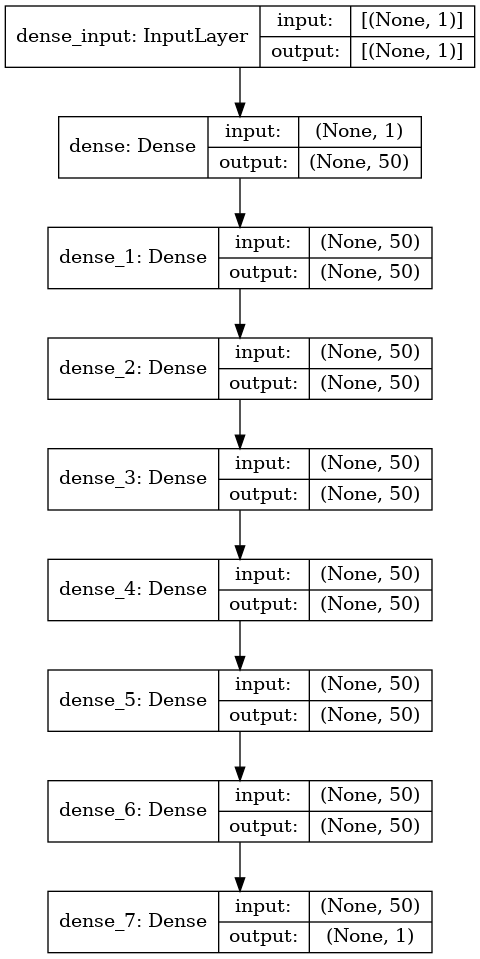

In [36]:
# Declaramos la red neuronal:
model = build_model(dim_feature , lr)

# Generamos un grafico sobre la arquitectura de la red:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='modelo.png', show_shapes = True)

In [37]:
# Usamos datos de entrenamiento y validación para entrenar la red neuronal:   
training = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size =n_batch_size,
    validation_data = (x_valid, y_valid),
    verbose=0 # 1 --> muestra el proceso de entrenamiento
)

In [38]:
# Extraemos las curvas de 'loss' y 'accuracy' para los datos de entrenamiento y validacion: 
loss_train_curve = training.history['loss']
accu_train_curve = training.history['mae']    

loss_valid_curve = training.history['val_loss']
accu_valid_curve = training.history['val_mae']

<Figure size 432x288 with 0 Axes>

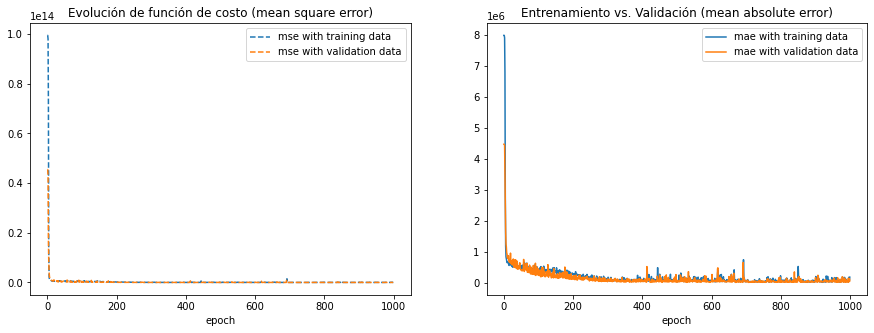

In [39]:
# Graficamos curvas:

# Eje x:
epoch = range( n_epochs )


plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, loss_train_curve, '--', label='mse with training data')
plt.plot(epoch, loss_valid_curve, '--', label='mse with validation data')
plt.legend()
plt.title('Evolución de función de costo (mean square error)')
plt.xlabel('epoch')


plt.subplot(1,2,2)
plt.plot(epoch, accu_train_curve, label='mae with training data')
plt.plot(epoch, accu_valid_curve, label='mae with validation data')
plt.legend()
plt.title('Entrenamiento vs. Validación (mean absolute error)')
plt.xlabel('epoch')
plt.show()

In [40]:
# Valores de métricas finales:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 13ms/step - loss: 16215876608.0000 - mae: 105780.2109


[16215876608.0, 105780.2109375]

In [41]:
# Predecimos las etiquetas para los features estandarizados
y_predict = model.predict(x_features)

y_predict.shape

(62, 1)

In [42]:
# Predecimos una etiqueta en particular:

i = 18 #<--- indice del valor a predecir (< 102)

y_obs  = y[i] #np.argmax(y_test[i])
y_aprx = y_predict[i]

print('    Etiqueta real: ', y_obs )
print('Etiqueta predicha: ', y_aprx )

    Etiqueta real:  2592474.0
Etiqueta predicha:  [2401619.2]


<Figure size 432x288 with 0 Axes>

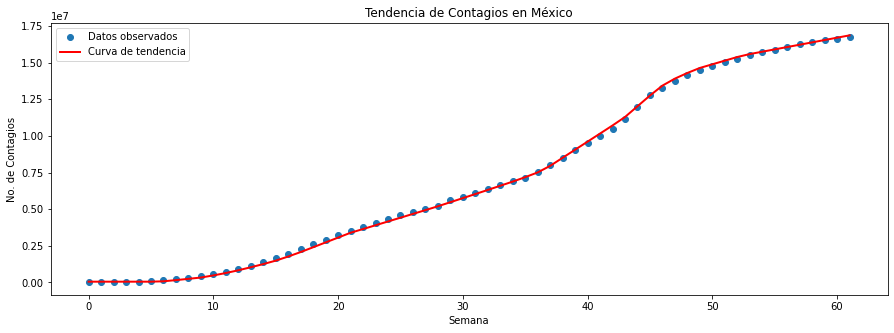

In [43]:
# Graficamos los datos:
plt.figure()
plt.figure( figsize=(15,5) )

plt.plot( x , y ,'o' , label='Datos observados')
plt.plot( x , y_predict , linewidth=2, c='red', label='Curva de tendencia')
plt.title('Tendencia de Contagios en México')
plt.xlabel('Semana')
plt.ylabel('No. de Contagios')
plt.legend()

plt.show()

## Hacemos una predicción a corto plazo

In [44]:
# número de valores a predecir:
Np = 10 # <-- próximas Np-semanas

# Límites de intervalo a predecir (continuación del eje x no estandarizado):
xa = x[-1][0]
xb = xa + Np

print('Haremos una predicción de la semana',xa,'a la semana',xb)

Haremos una predicción de la semana 61 a la semana 71


In [45]:
# Intervalo a predecir (continuación del eje x no estandarizado)
x2 = np.arange(xa,xb)
x2 = x2.reshape( x2.shape[0],1 )
x2 

array([[61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70]])

In [46]:
# concatenamos el intervalo de features:
#x2 = np.concatenate([x,x2])

In [47]:
# Estandarizamos con la media y la desviación de los features conocidos:
x_features2 = (x2-x_mu)/x_std
x_features2

array([[1.70433621],
       [1.76021608],
       [1.81609596],
       [1.87197583],
       [1.92785571],
       [1.98373558],
       [2.03961546],
       [2.09549534],
       [2.15137521],
       [2.20725509]])

In [48]:
# Predecimos las etiquetas para los features estandarizados
y_predict2 = model.predict(x_features2)

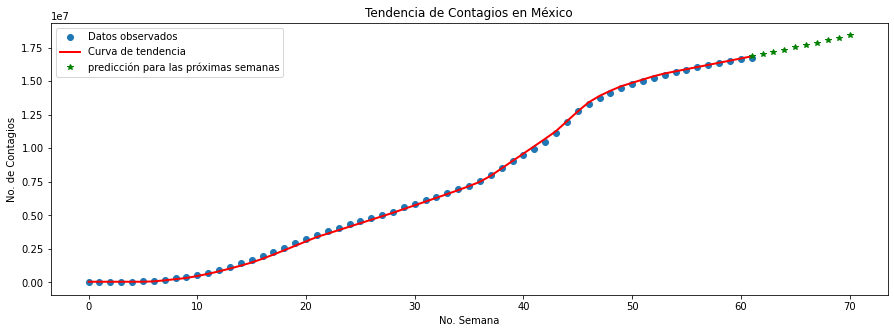

In [49]:
plt.figure(figsize=[15,5])
plt.plot( x , y ,'o' , label='Datos observados')
plt.plot( x , y_predict , linewidth=2, c='red', label='Curva de tendencia')
plt.plot( x2 , y_predict2, '*' ,linewidth=3, c='green' , label='predicción para las próximas semanas')
plt.legend()
plt.title('Tendencia de Contagios en México')
plt.xlabel('No. Semana')
plt.ylabel('No. de Contagios')
plt.show()

In [50]:
# Porcentaje de incremento en las proximas 10 semanas
y_predict2[-1][0]*100 / y[-1] - 100

10.09039909956536

### Se estima que en las próximas 10 semanas el número de contagios incremente hasta en un 10%